In [1]:
%matplotlib inline
path = "/data/jhoward/fast/planet/"

import utils
import importlib
importlib.reload(utils)
from utils import *

limit_mem()

batch_size=48
import vgg16; importlib.reload(vgg16)
from vgg16 import Vgg16
from sgdr import *

Using TensorFlow backend.


In [2]:
import os, json, numpy as np
from glob import glob

from keras import backend as K
from keras.layers import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Lambda, Input
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

In [3]:
from keras.utils.generic_utils import Progbar
from keras.utils.data_utils import GeneratorEnqueuer

def predict_to_bcolz(m, generator, preds, labels, workers=2, verbose=0):
    m._make_predict_function()
    steps=math.ceil(generator.n/generator.batch_size)
    
    try:
        enqueuer = GeneratorEnqueuer(generator, wait_time=0.01)
        enqueuer.start(workers=workers, max_queue_size=10)
        batches = enqueuer.get()
        if verbose == 1: progbar = Progbar(target=steps)

        for i in range(steps):
            batch = next(batches)
            x = batch[0]; y = batch[1]
            preds.append(m.predict_on_batch(x))
            labels.append(y)
            if verbose == 1: progbar.update(i)
        preds.flush()
        labels.flush()

    finally: enqueuer.stop()

In [4]:
def freeze_to(m, idx):
    print(f'-- freeze {idx}')
    if isinstance(idx, str): idx=m.layers.index(m.get_layer(idx))
    for layer in m.layers[idx:]: layer.trainable = True
    for layer in m.layers[:idx]: layer.trainable = False
    reset_trainable(m)

def unfreeze(m): freeze_to(m, 0)

def reset_trainable(m): 
    m._collected_trainable_weights = m.trainable_weights
    m.train_function = None
    
def set_trainable(m, name, t): 
    m.get_layer(name).trainable = t
    reset_trainable(m)

def set_lr(m, lr): 
    K.set_value(m.optimizer.lr, lr)
    print(f'-- lr {lr}')

In [5]:
trn_x = bcolz.open(rootdir=f'{path}trn_x.bc')
val_x = bcolz.open(rootdir=f'{path}val_x.bc')
trn_y = bcolz.open(rootdir=f'{path}trn_y.bc')
val_y = bcolz.open(rootdir=f'{path}val_y.bc')

In [27]:
csv_lines = [o.strip().split(',') for o in open(f'{path}train_v2.csv')][1:]
csv_labels = {a:b.split(' ') for a,b in csv_lines}
all_labels = list(set(p for o in csv_labels.values() for p in o))
label2idx = {v:k for k,v in enumerate(all_labels)}

c = len(all_labels)
n = len(csv_labels)

In [29]:
csv_lines[:5]

[['train_0', 'haze primary'],
 ['train_1', 'agriculture clear primary water'],
 ['train_2', 'clear primary'],
 ['train_3', 'clear primary'],
 ['train_4', 'agriculture clear habitation primary road']]

In [30]:
all_labels

['primary',
 'clear',
 'cultivation',
 'haze',
 'slash_burn',
 'conventional_mine',
 'bare_ground',
 'habitation',
 'road',
 'cloudy',
 'water',
 'blooming',
 'partly_cloudy',
 'selective_logging',
 'artisinal_mine',
 'agriculture',
 'blow_down']

In [31]:
label2idx

{'agriculture': 15,
 'artisinal_mine': 14,
 'bare_ground': 6,
 'blooming': 11,
 'blow_down': 16,
 'clear': 1,
 'cloudy': 9,
 'conventional_mine': 5,
 'cultivation': 2,
 'habitation': 7,
 'haze': 3,
 'partly_cloudy': 12,
 'primary': 0,
 'road': 8,
 'selective_logging': 13,
 'slash_burn': 4,
 'water': 10}

In [10]:
def n_hot(ids):
    res = np.zeros((c,))
    res[ids] = 1
    return res

In [32]:
fnames = sorted(csv_labels.keys())

In [33]:
fn=fnames[0]

In [37]:
n_hot([label2idx[o] for o in csv_labels[fn]])

array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
all_idx = {k: n_hot([label2idx[o] for o in v]) for k,v in csv_labels.items()}
labels = np.stack([all_idx[o] for o in fnames])

In [48]:
trn_x = bcolz.zeros((0,224,224,3), rootdir=f'{path}trn_x.bc', mode='w', chunklen=1, dtype='uint8')
val_x = bcolz.zeros((0,224,224,3), rootdir=f'{path}val_x.bc', mode='w', chunklen=1, dtype='uint8')

trn_y = bcolz.zeros((0,c), rootdir=f'{path}trn_y.bc', mode='w', chunklen=1, dtype='uint8')
val_y = bcolz.zeros((0,c), rootdir=f'{path}val_y.bc', mode='w', chunklen=1, dtype='uint8')

In [49]:
from tqdm import tqdm_notebook
import random as rnd

In [50]:
for fn,lbl in tqdm_notebook(zip(fnames,labels)):
    img = np.array(Image.open(f'{path}train-jpg/{fn}.jpg').convert('RGB').resize((224,224)))
    if rnd.random()<0.75:
        trn_x.append(img)
        trn_y.append(lbl)
    else:
        val_x.append(img)
        val_y.append(lbl)
for o in (trn_x, trn_y, val_x, val_y): o.flush()

### Class

In [141]:
class Vgg16():
    """
        The VGG 16 Imagenet model
    """
    vgg_mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((1,1,3))
    dense_layers = ['fc1', 'fc2', 'predictions']
    pre_bn_layers = ['flatten', 'fc1', 'fc2']

    def __init__(self, path=None, bs=48, vert_flip=False, ps=None, bn_layers=None, 
            data=None, class_idx=None, final_act='softmax',
            trn_name='train', val_name='valid', tmp_name='tmp', models_name='models',
            gen=image.ImageDataGenerator(horizontal_flip=True, rotation_range=5, 
                height_shift_range=0.05, width_shift_range=0.05,
                channel_shift_range=0.05)):
        self.FILE_PATH = 'http://files.fast.ai/models/'
        self.path,self.bs,self.ps,self.bn_layers = path,bs,ps,bn_layers
        self.final_act,self.data,self.class_idx = final_act,data,class_idx
        if data is not None: assert(class_idx is not None)
        self.bs=bs
        if path: 
            if not gen.preprocessing_function:
                gen.preprocessing_function=self.preprocess
            if vert_flip: gen.vertical_flip=True
            self.gen=gen
            self.setup_path(trn_name, val_name, tmp_name, models_name)
        else:
            self.model = VGG16()
        self.get_classes()
        
    def setup_path(self, trn_name, val_name, tmp_name, models_name):
        self.val_gen=image.ImageDataGenerator(preprocessing_function=self.preprocess)
        self.trn_path = os.path.join(path, trn_name)
        self.val_path = os.path.join(path, val_name)
        self.tmp_path = os.path.join(path, tmp_name)
        self.batches = self.get_batches()
        self.val_batches = self.get_batches(shuffle=False, is_trn=False)
        if not os.path.exists(self.tmp_path): os.mkdir(self.tmp_path)
        self.models_path = os.path.join(path, models_name)
        if not os.path.exists(self.models_path): os.mkdir(self.models_path)
        self.nb = math.ceil(self.batches.n/self.batches.batch_size)
        self.val_nb = math.ceil(self.val_batches.n/self.val_batches.batch_size)
        self.nc=data[1].shape[1] if self.data else self.batches.num_class
        self.create()

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), 
                            chunklen=1, mode='w', rootdir=name)

    def get_fc1_arrays(self, force=False):
        names = [os.path.join(self.tmp_path, p+'.bc') for p in (
                'arr', 'y_arr', 'arr_val', 'y_arr_val')]
        if os.path.exists(names[0]) and not force: 
            return [bcolz.open(p) for p in names]

        sizes = (4096, self.nc, 4096, self.nc) # 25088
        return [self.create_empty_bcolz(s,p) for s,p in zip(sizes, names)]

    def get_classes(self):
        """
            Downloads the Imagenet classes index file and loads it to self.classes.
            The file is downloaded only if it not already in the cache.
        """
        if self.batches:
            if not self.class_idx: self.class_idx = self.batches.class_indices
            self.classes = [0]*self.nc
            for label,idx in self.class_idx.items(): self.classes[idx]=label
        else:
            fname = 'imagenet_class_index.json'
            fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
            with open(fpath) as f: self.class_idx = json.load(f)
            self.nc = len(self.class_idx)
            self.classes = [self.class_idx[str(i)][1] for i in range(self.nc)]

    def preprocess(self, x):
        """
            Subtracts the mean RGB value, and transposes RGB to BGR.
            The mean RGB was computed on the image set used to train the VGG model.
            (Similar to .applications.imagenet_utils.preprocess_input)

            Args: 
                x: Image array (height x width x channels)
            Returns:
                Image array (height x width x transposed_channels)
        """
        return x[:, :, ::-1] - self.vgg_mean   # reverse axis rgb->bgr

    
    def get_path(self, is_trn): 
        return self.trn_path if is_trn else self.val_path
    
    def get_batches(self, shuffle=True, is_trn=True, class_mode='categorical'):
        """
            Generates batches of augmented/normalized data.
            Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        gen = self.gen if shuffle else self.val_gen
        if self.data:
            # self.data = trn_x, trx_y, val_x, val_y
            x,y = self.data[:2] if is_trn else self.data[2:]
            return gen.flow(x, y, shuffle=shuffle, batch_size=self.bs)
        else:
            return gen.flow_from_directory(self.get_path(is_trn), target_size=(224,224),
                    class_mode=class_mode, shuffle=shuffle, batch_size=self.bs)

    def get_bn_params(self):
        m=self.model
        batches = self.get_batches()
        x,y = next(batches)
        ms=[Model(m.input, m.get_layer(o).output) for o in self.pre_bn_layers]
        bn_inp = [m.predict_on_batch(x) for m in ms]
        means = [o.mean(0) for o in bn_inp]
        stds = [o.var(0) for o in bn_inp]
        bn_params = [(np.sqrt(s),m,m,s) for m,s in zip(means,stds)]
        for idx,keep in enumerate(self.bn_layers):
            if not keep: bn_params[idx]=0
        return bn_params

    def create_fc(self, x, nf, actn, name, p, bn, set_weights=True):
        if bn:
            bnl = BatchNormalization(name=name+'_bn')
            x = bnl(x)
            bnl.set_weights(bn)
        if p: x = Dropout(p, name=name+'_do')(x)
        fc = Dense(nf, activation=actn, name=name)
        x = fc(x)
        if set_weights: 
            fc.set_weights(self.model.get_layer(name).get_weights())
        return x
    
    def get_fc_model(self):
        m=self.model
        fc_start = m.get_layer('fc1')
        fc_start_idx = m.layers.index(fc_start)
        self.conv_model = Model(m.input, fc_start.output)
        fc_inp = Input(batch_shape=self.conv_model.output_shape)
        x=fc_inp
        fc_layers = m.layers[fc_start_idx+1:]
        for l in fc_layers: x=l(x)
        self.fc_model = Model(fc_inp, x)
    
    def create(self):
        self.model = VGG16()
        m=self.model
        if not self.ps: self.ps=[0]*3
        elif not isinstance(self.ps, list): self.ps = [0,0,self.ps]
        assert(len(self.ps)==3)

        if self.bn_layers: bn=self.get_bn_params()
        else: bn=[0]*3
        fl = m.get_layer('flatten')
        x = fl.output

        x = self.create_fc(x, 4096, 'relu', name='fc1', p=self.ps[0], bn=bn[0])
        x = self.create_fc(x, 4096, 'relu', 'fc2', self.ps[1], bn[1])
        x = self.create_fc(x, self.nc, self.final_act, 'predictions', 
                           self.ps[2], bn[2], set_weights=False)

        m.get_layer('fc1').input_nodes=None

        self.model = Model(m.input, x)
        self.save_fc1()
        freeze_to(self.model, -1)
        self.compile()
        
    def save_fc1(self):
        self.get_fc_model()
        arr, y_arr, arr_val, y_arr_val = self.get_fc1_arrays()
        if len(arr): return
        trn_batches = self.get_batches(shuffle=False, is_trn=True)
        predict_to_bcolz(self.conv_model, trn_batches, arr, y_arr, verbose=1)
        predict_to_bcolz(self.conv_model, self.val_batches, arr_val, y_arr_val, verbose=1)


    def predict(self, imgs, details=False):
        """
            Predict the labels of a set of images using the VGG16 model.

            Args:
                imgs (ndarray)    : An array of N images (size: N x width x height x channels).
                details : ??
            
            Returns:
                preds (np.array) : Highest confidence value of the predictions for each image.
                idxs (np.ndarray): Class index of the predictions with the max confidence.
                classes (list)   : Class labels of the predictions with the max confidence.
        """
        # predict probability of each class for each image
        all_preds = self.model.predict(imgs)
        # for each image get the index of the class with max probability
        idxs = np.argmax(all_preds, axis=1)
        # get the values of the highest probability for each image
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        # get the label of the class with the highest probability for each image
        classes = [self.classes[idx] for idx in idxs]
        return np.array(preds), idxs, classes

    def compile(self, lr=0.001, opt=None):
        """
            Configures the model for training.
        """
        if opt is None: opt=RMSprop(lr=lr)
        self.model.compile(opt, 'binary_crossentropy', ['accuracy'])


    def fit(self, epochs=1, workers=2, callbacks=None):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
        """
        nb = self.nb
        if epochs<1: 
            nb*=epochs
            epochs=1
        self.model.fit_generator(self.batches, steps_per_epoch=nb,
            epochs=epochs, validation_data=self.val_batches, validation_steps=self.val_nb,
            workers=workers, callbacks=callbacks)
        
    def clear_session(self):
        lr=K.get_value(self.model.optimizer.lr)
        self.save('tmp')
        self.model=None
        self.fc_model=None
        K.clear_session()
        limit_mem()
        self.create()
        self.load('tmp')
        K.set_value(self.model.optimizer.lr, lr)

    def set_lr(self, lr): set_lr(self.model, lr)
    def get_model_path(self, name): return os.path.join(self.models_path,name)+'.h5'
    def save(self, name): self.model.save_weights(self.get_model_path(name))
    def load(self, name): self.model.load_weights(self.get_model_path(name))

In [142]:
def set_wd(m, wd):
    for l in m.layers[:-1]:
        if isinstance(l, (Dense, Conv2D)): l.kernel_regularizer = regularizers.l2(wd)

In [143]:
class CosAnneal(LossRecorder):
    def __init__(self, nb, init_lr=0.1):
        super().__init__()
        self.check = nb
        self.init_lr = init_lr

    def on_train_begin(self, logs={}):
        super().on_train_begin(logs)
        K.set_value(self.lr, self.init_lr)
    
    def on_batch_end(self, epoch, logs=None):
        super().on_batch_end(epoch, logs)
        K.set_value(self.lr, self.cos_anneal())

    def cos_anneal(self):
        cos_inner = np.pi * ((self.iterations-2) % (self.check))
        cos_out = np.cos(cos_inner/self.check) + 1
        return float(self.init_lr / 2 * cos_out)

In [144]:
class LR_Finder(LossRecorder):
    def __init__(self, nb, start_lr=1e-6, end_lr=10, patience=20, loss_mom=0.9):
        super().__init__()
        self.lr_mult = (end_lr/start_lr)**(1/nb)
        self.start_lr,self.patience,self.loss_mom = start_lr,patience,loss_mom

    def incr_lr(self):
        return self.start_lr * (self.lr_mult**self.iterations)
    
    def on_train_begin(self, logs={}):
        super().on_train_begin(logs)
        self.best=1e9
        self.best_iters=0
        self.avg_loss = None
        K.set_value(self.lr, self.incr_lr())
            
    def on_batch_end(self, epoch, logs=None):
        super().on_batch_end(epoch, logs)
        K.set_value(self.lr, self.incr_lr())
        loss=logs.get('loss')
        if self.avg_loss is None: self.avg_loss=loss
        else: self.avg_loss = self.avg_loss*self.loss_mom + loss*(1-self.loss_mom)
        self.losses[-1]=self.avg_loss
        if self.iterations<10: return
        
        if self.avg_loss>self.best*4:
            self.best_iters+=1
            if self.best_iters>self.patience:
                self.model.stop_training = True
        else:
            self.best_iters=0
            if self.avg_loss<self.best: self.best=self.avg_loss

#### Full run

In [145]:
ps=[0.,0.5,0.5]
bn_layers=None

In [146]:
vgg.clear_session()

-- freeze -1


In [65]:
data=[trn_x, trn_y, val_x, val_y]

In [66]:
vgg=Vgg16(path, ps=ps, bn_layers=bn_layers, data=data, class_idx=label2idx, final_act='sigmoid')

-- freeze -1


In [67]:
vgg.fc_model.compile(RMSprop(), 'binary_crossentropy', metrics=['accuracy'])
arr, y_arr, arr_val, y_arr_val = vgg.get_fc1_arrays()
val_data = (arr_val, y_arr_val)

Train on 30260 samples, validate on 10219 samples
Epoch 1/1
19104/30260 [=================>............] - ETA: 3s - loss: 0.1942 - acc: 0.9396

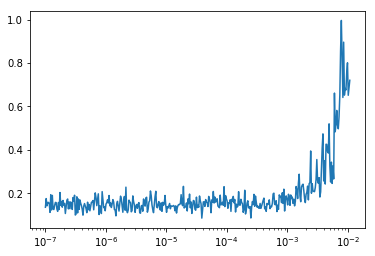

In [93]:
cb = LR_Finder(vgg.nb, start_lr=1e-7, end_lr=10)
vgg.fc_model.fit(arr, y_arr, epochs=1, validation_data=(arr_val, y_arr_val), batch_size=48, 
                 callbacks=[cb], verbose=1)

plt.plot(cb.history['lr'], cb.losses)
plt.xscale('log');

In [126]:
vgg.clear_session()

-- freeze -1


In [127]:
ps=[0.25,0.25,0.5]
bn_layers=None

In [147]:
vgg=Vgg16(path, ps=ps, bn_layers=bn_layers, data=data, class_idx=label2idx,
          final_act='sigmoid', vert_flip=True)

-- freeze -1


In [129]:
vgg.fc_model.compile(RMSprop(), 'binary_crossentropy', metrics=['accuracy'])

In [130]:
set_lr(vgg.fc_model, 1e-4)
vgg.fc_model.fit(arr, y_arr, epochs=4, validation_data=(arr_val, y_arr_val), batch_size=48)

-- lr 0.0001
Train on 30260 samples, validate on 10219 samples
Epoch 1/4
30260/30260 [==============================] - 10s - loss: 0.1946 - acc: 0.9270 - val_loss: 0.1409 - val_acc: 0.9473
Epoch 2/4
30260/30260 [==============================] - 10s - loss: 0.1566 - acc: 0.9420 - val_loss: 0.1331 - val_acc: 0.9498
Epoch 3/4
30260/30260 [==============================] - 10s - loss: 0.1499 - acc: 0.9446 - val_loss: 0.1298 - val_acc: 0.9510
Epoch 4/4
30260/30260 [==============================] - 10s - loss: 0.1452 - acc: 0.9465 - val_loss: 0.1284 - val_acc: 0.9517


In [131]:
set_lr(vgg.fc_model, 1e-5)
vgg.fc_model.fit(arr, y_arr, epochs=4, validation_data=(arr_val, y_arr_val), batch_size=48)

-- lr 1e-05
Train on 30260 samples, validate on 10219 samples
Epoch 1/4
30260/30260 [==============================] - 10s - loss: 0.1430 - acc: 0.9470 - val_loss: 0.1276 - val_acc: 0.9520
Epoch 2/4
30260/30260 [==============================] - 10s - loss: 0.1431 - acc: 0.9474 - val_loss: 0.1274 - val_acc: 0.9521
Epoch 3/4
30260/30260 [==============================] - 11s - loss: 0.1420 - acc: 0.9479 - val_loss: 0.1273 - val_acc: 0.9522
Epoch 4/4
30260/30260 [==============================] - 10s - loss: 0.1428 - acc: 0.9474 - val_loss: 0.1272 - val_acc: 0.9523


In [132]:
def fc_cos(vgg, nc,  cl, lr, tmult=1):
    for i in range(nc):
        cb = CosAnneal(vgg.nb, init_lr=lr)
        vgg.fc_model.fit(arr, y_arr, epochs=cl, validation_data=(arr_val, y_arr_val),
                         batch_size=48, callbacks=[cb])
        cl *= tmult

In [86]:
fc_cos(vgg, nc=3, cl=5, lr=1e-4)

Train on 30260 samples, validate on 10219 samples
Epoch 1/5
30260/30260 [==============================] - 12s - loss: 0.1585 - acc: 0.9418 - val_loss: 0.1335 - val_acc: 0.9494
Epoch 2/5
30260/30260 [==============================] - 12s - loss: 0.1567 - acc: 0.9428 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 3/5
30260/30260 [==============================] - 12s - loss: 0.1541 - acc: 0.9436 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 4/5
30260/30260 [==============================] - 12s - loss: 0.1524 - acc: 0.9444 - val_loss: 0.1318 - val_acc: 0.9503
Epoch 5/5
30260/30260 [==============================] - 12s - loss: 0.1505 - acc: 0.9452 - val_loss: 0.1321 - val_acc: 0.9504
Train on 30260 samples, validate on 10219 samples
Epoch 1/5
30260/30260 [==============================] - 12s - loss: 0.1493 - acc: 0.9455 - val_loss: 0.1321 - val_acc: 0.9502
Epoch 2/5
30260/30260 [==============================] - 12s - loss: 0.1482 - acc: 0.9461 - val_loss: 0.1329 - val_acc: 0.9498
Epoch 3/5
3

In [133]:
vgg.save('preaug')

In [134]:
freeze_to(vgg.fc_model, 'fc2')

-- freeze fc2


Train on 30260 samples, validate on 10219 samples
Epoch 1/1
16032/30260 [==============>...............] - ETA: 7s - loss: 0.1875 - acc: 0.9434

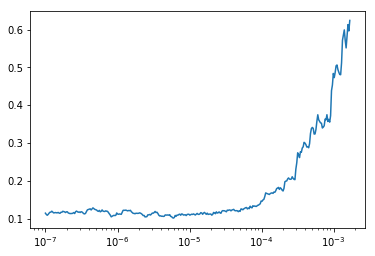

In [108]:
cb = LR_Finder(vgg.nb, start_lr=1e-7, end_lr=10)
vgg.fc_model.fit(arr, y_arr, epochs=1, validation_data=(arr_val, y_arr_val), batch_size=48, 
                 callbacks=[cb], verbose=1)

plt.plot(cb.history['lr'], cb.losses)
plt.xscale('log');

In [109]:
vgg.load('preaug')

In [135]:
freeze_to(vgg.fc_model, 'fc2')

-- freeze fc2


In [136]:
set_lr(vgg.fc_model, 1e-5)
vgg.fc_model.fit(arr, y_arr, epochs=2, validation_data=val_data, batch_size=48)

-- lr 1e-05
Train on 30260 samples, validate on 10219 samples
Epoch 1/2
30260/30260 [==============================] - 16s - loss: 0.1358 - acc: 0.9492 - val_loss: 0.1212 - val_acc: 0.9542
Epoch 2/2
30260/30260 [==============================] - 16s - loss: 0.1266 - acc: 0.9524 - val_loss: 0.1183 - val_acc: 0.9555


In [137]:
from sklearn.metrics import fbeta_score
p_valid = vgg.fc_model.predict(arr_val, batch_size=64)
fbeta_score(np.array(y_arr_val), np.array(p_valid) > 0.2, beta=2, average='samples')

0.89359842822846525

In [138]:
vgg.save('preaug2')

In [148]:
vgg.load('preaug2')

In [139]:
vgg.clear_session()

-- freeze -1


In [149]:
freeze_to(vgg.model, 'fc2')
vgg.set_lr(1e-5)
vgg.fit(2)
freeze_to(vgg.model, 'fc1')
vgg.fit(2)
freeze_to(vgg.model, 6)
vgg.fit(3)
vgg.clear_session()
unfreeze(vgg.model)
vgg.set_lr(1e-6)
vgg.fit(2)

-- freeze fc2
-- lr 1e-05
Epoch 1/2
631/631 [==============================] - 242s - loss: 0.1371 - acc: 0.9491 - val_loss: 0.1237 - val_acc: 0.9536
Epoch 2/2
631/631 [==============================] - 242s - loss: 0.1326 - acc: 0.9502 - val_loss: 0.1219 - val_acc: 0.9543
-- freeze fc1
Epoch 1/2
631/631 [==============================] - 273s - loss: 0.1278 - acc: 0.9520 - val_loss: 0.1167 - val_acc: 0.9562
Epoch 2/2
631/631 [==============================] - 272s - loss: 0.1205 - acc: 0.9547 - val_loss: 0.1126 - val_acc: 0.9574
-- freeze 6
Epoch 1/3
631/631 [==============================] - 499s - loss: 0.1075 - acc: 0.9596 - val_loss: 0.0990 - val_acc: 0.9623
Epoch 2/3
631/631 [==============================] - 496s - loss: 0.0976 - acc: 0.9634 - val_loss: 0.0964 - val_acc: 0.9640
Epoch 3/3
631/631 [==============================] - 496s - loss: 0.0940 - acc: 0.9647 - val_loss: 0.0918 - val_acc: 0.9654
-- freeze -1
-- freeze 0
-- lr 1e-06
Epoch 1/2
631/631 [========================

In [ ]:
vgg.set_lr(1e-7)
vgg.fit(4)

In [29]:
# RMSprop test on same as above full run
# TTA
# Learning rate finder here

In [30]:
# vgg.fc_model.compile(SGD(momentum=0.9), 'categorical_crossentropy', metrics=['accuracy'])
# cb = CosAnneal(vgg.nb, 1, init_lr=0.1)
# vgg.fc_model.fit(arr, y_arr, epochs=3, validation_data=(arr_val, y_arr_val), batch_size=48, 
#                  callbacks=[cb])

### Add dropout

In [6]:
from vgg16 import create_vgg

In [7]:
vgg = create_vgg([0.25, 0.25, 0.5])

In [10]:
gen = image.ImageDataGenerator(horizontal_flip=True, rotation_range=5, 
       height_shift_range=0.05, width_shift_range=0.05,
       preprocessing_function=vgg_preprocess)

batches = vgg.get_batches(path+'train', batch_size=batch_size, gen=gen)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size, shuffle=False)

In [11]:
vgg.fit(batches, val_batches, epochs=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
360/359 [==============================] - 137s - loss: 0.1221 - acc: 0.9661 - val_loss: 0.0670 - val_acc: 0.9795


In [12]:
vgg.fit(batches, val_batches, epochs=2)

Epoch 1/2
360/359 [==============================] - 133s - loss: 0.0954 - acc: 0.9755 - val_loss: 0.0694 - val_acc: 0.9820
Epoch 2/2
360/359 [==============================] - 133s - loss: 0.1018 - acc: 0.9773 - val_loss: 0.0653 - val_acc: 0.9820


In [13]:
K.set_value(vgg.model.optimizer.lr, 1e-4)

In [14]:
vgg.fit(batches, val_batches, epochs=2)

Epoch 1/2
360/359 [==============================] - 134s - loss: 0.0797 - acc: 0.9804 - val_loss: 0.0505 - val_acc: 0.9875
Epoch 2/2
360/359 [==============================] - 133s - loss: 0.0725 - acc: 0.9820 - val_loss: 0.0499 - val_acc: 0.9860


In [15]:
vgg.unfreeze()

In [17]:
vgg.model.save(f"{path}models/unfreeze.h5")

In [16]:
from keras.models import load_model

In [ ]:
vgg = Vgg16(load_model(f"{path}models/unfreeze.h5"))

In [18]:
K.set_value(vgg.model.optimizer.lr, 1e-5)

In [19]:
vgg.fit(batches, val_batches, epochs=2)

Epoch 1/2
360/359 [==============================] - 462s - loss: 0.0642 - acc: 0.9813 - val_loss: 0.0322 - val_acc: 0.9875
Epoch 2/2
360/359 [==============================] - 451s - loss: 0.0278 - acc: 0.9900 - val_loss: 0.0289 - val_acc: 0.9905


In [20]:
K.set_value(vgg.model.optimizer.lr, 1e-6)

In [21]:
vgg.fit(batches, val_batches, epochs=2)

Epoch 1/2
360/359 [==============================] - 450s - loss: 0.0120 - acc: 0.9956 - val_loss: 0.0247 - val_acc: 0.9915
Epoch 2/2
360/359 [==============================] - 450s - loss: 0.0103 - acc: 0.9964 - val_loss: 0.0271 - val_acc: 0.9905


In [14]:
bs=64
nb=batches.n/bs; nb

359.375

In [ ]:
from sgdr import *

In [13]:
start=1e-5
end=10.
ratio = end/start
step = ratio**(1/nb); step

cb = CosAnneal(nb, 1, init_lr=3e-4)

cb = LR_Finder(lr_mult=step)

In [17]:
bnvgg.fit(batches, val_batches, epochs=1, callbacks=[cb])

Epoch 1/1
360/359 [==============================] - 438s - loss: 3.8501 - acc: 0.6853 - val_loss: 8.0151 - val_acc: 0.5000


In [51]:
max_x=120
iters=cb.history['iterations'][:max_x]
plt.plot(cb.history['lr'][:max_x], cb.losses[:max_x])
plt.xscale('log');

NameError: name 'cb' is not defined

In [25]:
K.set_value(bnvgg.model.optimizer.lr, 2e-4)

In [26]:
bnvgg.fit(batches, val_batches, epochs=2)

Epoch 1/2
360/359 [==============================] - 437s - loss: 0.0711 - acc: 0.9795 - val_loss: 0.0852 - val_acc: 0.9755
Epoch 2/2
360/359 [==============================] - 435s - loss: 0.0430 - acc: 0.9855 - val_loss: 0.0270 - val_acc: 0.9890


In [28]:
cb = CosAnneal(nb, 1, init_lr=3e-4)

In [29]:
bnvgg.fit(batches, val_batches, epochs=2, callbacks=[cb])

Epoch 1/2
360/359 [==============================] - 436s - loss: 0.0318 - acc: 0.9891 - val_loss: 0.0328 - val_acc: 0.9880
Epoch 2/2
360/359 [==============================] - 435s - loss: 0.0220 - acc: 0.9922 - val_loss: 0.0373 - val_acc: 0.9895


## Use Vgg16 for basic image recognition

Let's start off by using the *VGG16* to recognise the main imagenet category for each image.

We won't be able to enter the Cats vs Dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead each individual breed is a separate category. However, we can use it to see how well it can recognise the images, which is a good first step.

First, create a Vgg16 object:

In [30]:
vgg = Vgg16()

Vgg16 is built on top of *Keras* (which we will be learning much more about shortly!), a flexible, easy to use deep learning library that sits on top of Theano or Tensorflow. Keras reads groups of images and labels in *batches*, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

Let's grab batches of data from our training folder:

In [31]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 23000 images belonging to 2 classes.


(BTW, when Keras refers to 'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [32]:
imgs, labels = next(batches)

As you can see, the labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog. This approach to encoding categorical variables, where an array containing just a single 1 in the position corresponding to the category, is very common in deep learning. It is called *one hot encoding*. 

The arrays contain two elements, because we have two categories (cat, and dog). If we had three categories (e.g. cats, dogs, and kangaroos), then the arrays would each contain two 0's, and one 1.

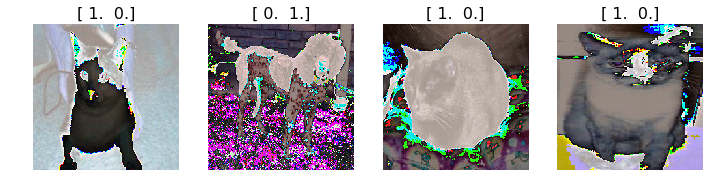

In [33]:
plots(imgs, titles=labels)

We can now pass the images to VGG16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [34]:
vgg.predict(imgs, True)

(array([ 0.1444,  0.9955,  0.4692,  0.9514], dtype=float32),
 array([285, 267, 750, 284]),
 ['Egyptian_cat', 'standard_poodle', 'quilt', 'Siamese_cat'])

In [35]:
vgg.classes[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [36]:
batch_size=64

In [37]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [38]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [40]:
vgg.fit(batches, val_batches, epochs=1)

Epoch 1/1
360/359 [==============================] - 132s - loss: 0.0718 - acc: 0.9774 - val_loss: 0.0745 - val_acc: 0.9815

That shows all of the steps involved in using the Vgg16 class to create an image recognition model using whatever labels you are interested in. For instance, this process could classify paintings by style, or leaves by type of disease, or satellite photos by type of crop, and so forth.

Next up, we'll dig one level deeper to see what's going on in the Vgg16 class.

# Create a VGG model from scratch in Keras

For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [54]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Model 
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [42]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [43]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [64]:
def ConvBlock(x, filters, num_conv=2, base_name="block1"):
    for i in range(num_conv):
        name_conv = base_name + "_conv" + str(i + 1)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same', name=name_conv)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name=base_name+'_pool')(x)
    return x

In [60]:
input_shape = (224, 224, 3)

In [61]:
img_input = Input(shape=input_shape)

Here is how we define the simple model using the first convolutional block

In [65]:
x = ConvBlock(img_input, 64)
model = Model(img_input, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
Total params: 38,720.0
Trainable params: 38,720.0
Non-trainable params: 0.0
_________________________________________________________________


...and here's the fully-connected definition.

In [72]:
def FCBlock(x):
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)
    return x

Here is how to define VGG16

In [73]:
x = ConvBlock(img_input, 64)
x = ConvBlock(x, 128, base_name="block2")
x = ConvBlock(x, 256, num_conv=3, base_name="block3")
x = ConvBlock(x, 512, num_conv=3, base_name="block4")
x = ConvBlock(x, 512, num_conv=3, base_name="block5")
x = FCBlock(x)
model = Model(img_input, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [46]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.
        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x[:, :, ::-1] # reverse axis rgb->bgr
    x = x - vgg_mean
    return x

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [28]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [29]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [30]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [31]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [32]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


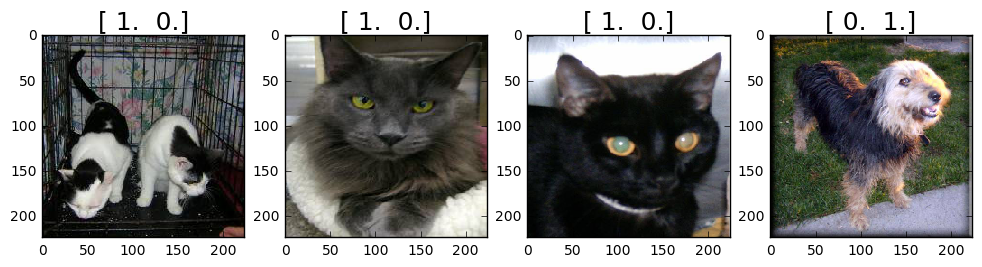

In [33]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [34]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [35]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.1169e-08   1.7160e-07   2.2501e-06   2.3426e-08   5.9417e-08]

Predictions prob/class: 
  0.2285/papillon
  0.2947/lynx
  0.6434/Egyptian_cat
  0.4845/Australian_terrier


## Exercises

1. Use this code in a similar dataset. TODO (yannet) find a dataset. 
2. Write code to finetune more than one layer. For example you can finetune all Dense layers. 